<a href="https://colab.research.google.com/github/tallywiesenberg/DS-Unit-2-Kaggle-Challenge/blob/master/assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Try other [scikit-learn scalers](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```



In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
##TRAIN / VAL SPLIT
from sklearn.model_selection import train_test_split
train, val = train_test_split(train,
                                                  test_size = 0.8, train_size = 0.2,
                                                  random_state = 42,
                                                  shuffle = True,
                                                  stratify = train['status_group']
                             )
train.shape, val.shape

((11880, 41), (47520, 41))

In [0]:
#pipeline
import numpy as np
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
def wrangle_tanzania(X):
  '''wrangle tanzania dataset'''
  X = X.copy()
  cols_with_zeros = ['longitude', 'latitude', 'construction_year']
  for col in cols_with_zeros:                                                             #eliminate "null island"
    X[col] = X.replace(0, np.nan)

  X['latitude'] = X['latitude'].replace(-2e-08, np.nan)                                    #remove latitude values outside tanzania

  X['year_recorded'] = pd.to_datetime(X['date_recorded']).dt.year                          #transform to datetime, isolate year

  X['years_since_construction'] = X['year_recorded'] - X['construction_year']              #new series: years since construction

  X = X.drop(columns='date_recorded').drop(columns='id')

  impute_mean = SimpleImputer(strategy='mean')                                             #imputer with mean
  impute_mode = SimpleImputer(strategy='most_frequent')                                    #imputer with mode

  ##IMPUTING
  
  mask = X.select_dtypes('object').nunique() < 15
  categorical_features = X.select_dtypes('object').columns[mask].tolist()                        #categorical features mask
  X[categorical_features] = impute_mode.fit_transform(X[categorical_features].values)      #fit and transform object columns with mode

  numerical_features = X.select_dtypes('number').columns.tolist()       #numeric features mask
  X[numerical_features] = impute_mean.fit_transform(X[numerical_features].values)          #for other dtypes, fit and transform with mean
  
  ##SEPARATE X AND Y
  features = categorical_features + numerical_features
  target = 'status_group'

  X_set = (X[features]
#            .drop(target, axis= 1)
          )
  X_set = X_set.reset_index(drop=True)
#   y_set = X[target]
#   y_set = y_set.reset_index(drop=True)
  X_set = X_set.values

  return X_set

def tanzania_pipeline(X_set, y_set,
                         encoder=OneHotEncoder(use_cat_names=True),
                         selector=SelectKBest(score_func=f_classif, k=10),
                         scaler=StandardScaler(),
                         model=LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)):
  '''for given X training/val/test set, this function cleans, engineers new features, fits and tests models'''
  
  ##PIPELINE PROPER

  pipeline = make_pipeline(encoder,
                           selector,
                           scaler,
                           model)

  pipeline.fit(X_set, y_set)
  
  score = pipeline.score(X_set, y_set)
  return score

  

In [0]:
from sklearn.metrics import accuracy_score
#baseline

train['status_group'].value_counts(normalize=True)
y_pred = ['functional'] * len(train['status_group'])
y_true = train['status_group']
baseline_score = accuracy_score(y_true, y_pred)

print('Baseline Score:', baseline_score)

Baseline Score: 0.5430976430976431


In [0]:
X_train, y_train = wrangle_tanzania(train)

X_val, y_val = wrangle_tanzania(val)

In [0]:
#logistic regression benchmark
pipeline = make_pipeline(OneHotEncoder(use_cat_names=True),
                         SelectKBest(score_func=f_classif, k=15),
                         StandardScaler(),
                         LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1))

pipeline.fit(X_train, y_train)
train_score = pipeline.score(X_train, y_train)
val_score = pipeline.score(X_val, y_val)

print('Train Score', train_score)
print('Validation Score', val_score)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [10] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Train Score 0.6992424242424242
Validation Score 0.6996001683501684


In [0]:
from sklearn.tree import DecisionTreeClassifier
#decision tree
pipeline = make_pipeline(OrdinalEncoder(),
                         SelectKBest(score_func=f_classif, k= 15),
                         StandardScaler(),
                         DecisionTreeClassifier(max_depth=10, min_samples_split=100))
pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
val_score = pipeline.score(X_val, y_val)

print('Train Score', train_score)
print('Validation Score', val_score)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [2] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Train Score 0.7451178451178451
Validation Score 0.7266624579124579


Text(0.5, 1.0, 'Feature Importances')

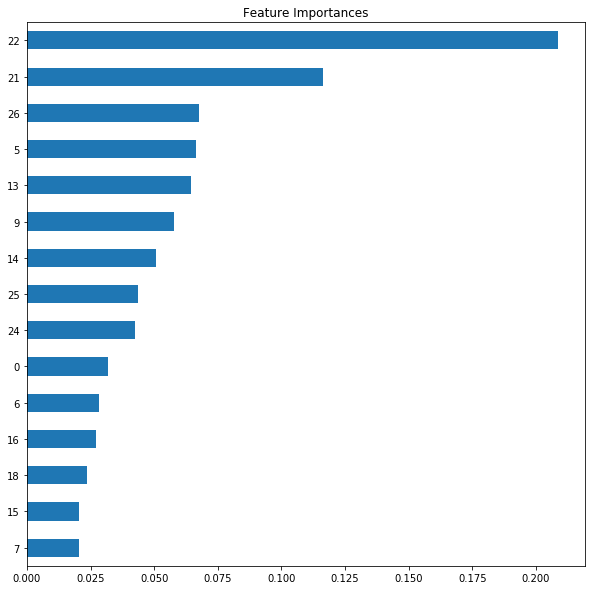

In [0]:
, #feature importances
import matplotlib.pyplot as plt
%matplotlib inline
dt = pipeline.named_steps['decisiontreeclassifier']         #isolate decision tree pipeline step
encoder = pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(X_train)
importances = pd.Series(dt.feature_importances_,            #feature importances
                        encoded.columns)                    #columns after encoding
n = 15

plt.figure(figsize=(10, 10))
importances.sort_values()[-n:].plot.barh()
plt.title('Feature Importances')

In [0]:
test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [0]:
#export
X_test = wrangle_tanzania(test)
y_pred = pipeline.predict(X_test)

In [0]:
sample_submission['status_group'] = y_pred

In [0]:
sample_submission.to_csv('submission.csv')